# Fisher's Linear Discriminant

- A way to view a linear classification model is in terms of dimensionality reduction.
- So we are projecting the data from X-space to a lower dimension y-space using $y = W^TX$.
- $W$ must results a projected data with:
    - Minimum separation within each class data
    $$S_W = \sum_{k=1}^K S_k^2, \text{where } S_k^2 = \sum_{n\in c_k}(y_n - M_k)^2 \text{ , } M_k = W^Tm_k \text{ , } m_k = \frac{1}{N_k}\sum_{n\in c_k}x_n$$
    - Maximum separation between all classes
    $$S_B = \sum_{k=1}^KN_k(\mu_k - \mu)(\mu_k - \mu)^T, \text{where } \mu_k = \frac{1}{N_k}\sum_{n\in k}y_n \text{ , } \mu = \frac{1}{N}\sum_{k=1}^KN_k \mu_k$$
    
- For two-class problem:
    - $W^* = S^{-1}(m_2 - m_1)$
    
    
- Then apply some threshold to classify the data. 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from utils import plot_DR, plot_DB
%matplotlib inline

In [12]:
X, y = make_blobs(n_samples=100, centers=5, n_features=2, cluster_std=2, random_state=20)

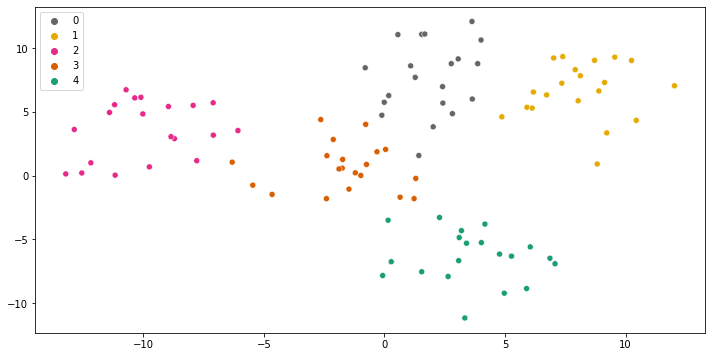

In [13]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='Dark2_r');

In [14]:
class FLD:
    def __init__(self, threshold=None):
        self.threshold = threshold
    
    def fit(self, X, y):
        self.num_c = len(np.unique(y))
        self.mus = np.array([X[np.nonzero(y==i)].mean(axis=0).reshape(-1,1) for i in range(self.num_c)])
        self.covs = np.array([np.cov(X[np.nonzero(y==i)].T) for i in range(self.num_c)])

        SW = np.sum(self.covs, axis=0)
        self.W = np.linalg.solve(SW, self.mus[1] - self.mus[0])
        self.W /= np.linalg.norm(self.W).clip(min=1e-10)

        # Initialize a dictionary to store the thresholds for each pair of classes
        self.thresholds = {}

        # Loop over all pairs of classes
        for i in range(self.num_c):
            for j in range(i+1, self.num_c):
                # Compute the threshold for this pair of classes
                self.thresholds[(i, j)] = self.get_threshold(X, y, i, j)

    def get_threshold(self, X, y, class_a, class_b):
        # Select samples from class_a and class_b
        X0 = X[y == class_a]
        X1 = X[y == class_b]

        # Compute the mean and standard deviation for each class
        m1, m2 = X0.mean(), X1.mean()
        std1, std2 = X0.std(), X1.std()

        # Compute the threshold using the means and standard deviations
        a = 1/(2*std1**2) - 1/(2*std2**2)
        b = m2/(std2**2) - m1/(std1**2)
        c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
        roots = np.roots([a,b,c])

        # Return the root that falls between the means of the two classes
        if m1 < roots[0] < m2 or m2 < roots[0] < m1: return np.array(roots[0])
        else: return np.array(roots[1])

    def project(self, X):
        return X.dot(self.W)
    
    def predict(self, X):
        # Create an array to store the scores for each class
        scores = np.zeros((X.shape[0], self.num_c))

        # Loop over all pairs of classes
        for i in range(self.num_c):
            for j in range(i+1, self.num_c):
                # Compute the scores for each class using the threshold for this pair of classes
                scores[:, i] += (self.project(X) > self.thresholds[(i, j)]).flatten()
                scores[:, j] += (self.project(X) < self.thresholds[(i, j)]).flatten()

        # Return the class with the highest score for each sample
        return np.argmax(scores, axis=1)

    
    def visualize(self, X, y, title=''):
        plt.figure(figsize=(12, 6))
        plt.plot([-self.W[0], self.W[0]], [-self.W[1], self.W[1]])
        plt.plot(self.mus[0][0], self.mus[0][1], 'g*', label='Means')
        plt.plot(self.mus[1][0], self.mus[1][1], 'g*')
        plt.title(title)
        
        W_norm = np.linalg.norm(self.W.reshape(2,))**2

        for (x, c), l in zip(zip([X[y==0], X[y==1]], ['r','b']), ['Class 0', 'Class 1']):
            for i, p in enumerate(x):
                prj = self.W.reshape(2,) * self.project(p) / W_norm
                plt.plot([prj[0], p[0]], [prj[1], p[1]], '{}.:'.format(c), alpha=0.4, label=l if i==0 else None)
                
        plt.legend()

In [15]:
model = FLD()
model.fit(X, y)

In [16]:
acc = str(100*sum(model.predict(X)==y)/len(y))+'%'
print('Accuracy: {}'.format(acc))

Accuracy: 9.0%


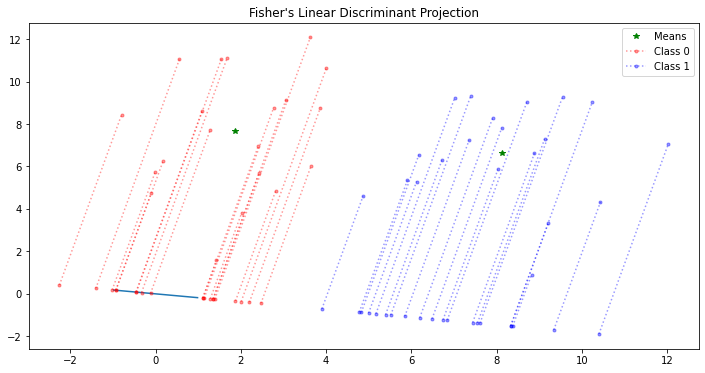

In [17]:
model.visualize(X, y, 'Fisher\'s Linear Discriminant Projection')

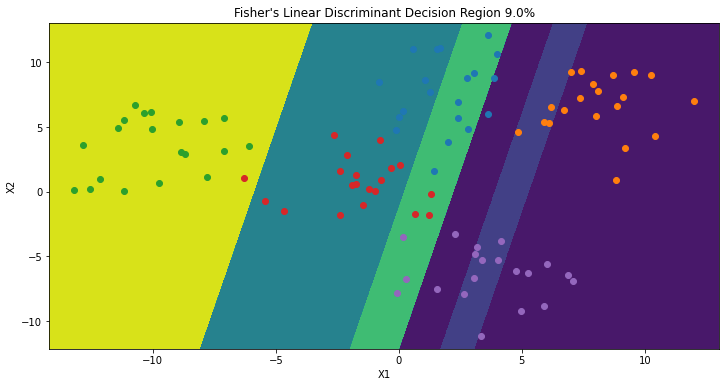

In [18]:
plot_DR(X, y, model, 'Fisher\'s Linear Discriminant Decision Region {}'.format(acc))

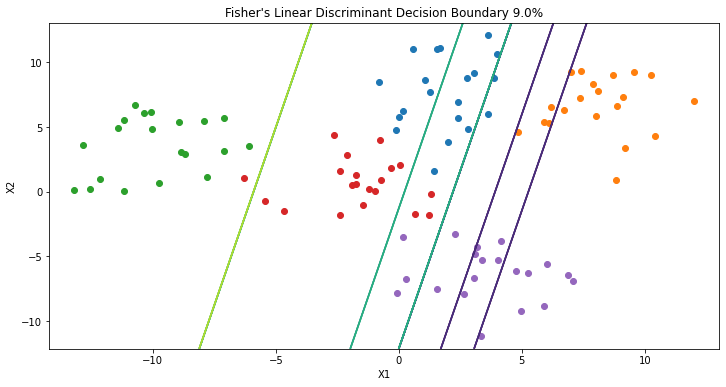

In [19]:
plot_DB(X, y, model, 'Fisher\'s Linear Discriminant Decision Boundary {}'.format(acc))